In [1]:
!pwd

/Users/ashish1610dhiman/data_projects/bestbuy/notebooks/ashish


In [2]:
import sys
import matplotlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime

sys.version

sys.path.append("../../")

from src.ad_hmm import sku_predict
from src.utils import *

In [3]:
%load_ext autoreload 
%autoreload 2

### Read data

In [4]:
train_test = pd.read_csv("../../data/train_validation_marker.csv")
train_test["SALES_DATE"] = pd.to_datetime(train_test["SALES_DATE"])
print (train_test.shape)

(846632, 15)


In [5]:
# #clean train/test
# train = train_test[(train_test.validation==False) & (train_test.validation_clean==True)]
# validation = train_test[(train_test.validation==True) & (train_test.validation_clean==True)]
# train.shape,validation.shape

In [6]:
train_test["if_promo"] = (~train_test["PROMO_PRICE"].isin(["?"])).astype("int")
train_test["if_competitor"] = (~train_test["COMPETITOR_PRICE"].isin(["?"])).astype("int")

train_test["min_sales_price"] = pd.to_numeric(np.where(train_test.if_promo>0, train_test.PROMO_PRICE,\
                                                       train_test.RETAIL_PRICE))

In [7]:
train_test["comp_price_clean"] = pd.to_numeric(np.where(train_test.if_competitor>0,train_test.COMPETITOR_PRICE, np.nan))
train_test["price_delta"] = np.where(train_test.if_competitor>0, train_test.min_sales_price - train_test.comp_price_clean,\
                                   -train_test.min_sales_price)

### Transform data

In [8]:
train_test_pivot = train_test.pivot(index='SALES_DATE', columns='Encoded_SKU_ID',\
                   values=['DAILY_UNITS',"if_promo","if_competitor","min_sales_price","price_delta",\
                          "validation","validation_clean"])

In [9]:
train_test_pivot.columns = train_test_pivot.columns.swaplevel(0, 1)
train_test_pivot.columns

MultiIndex([(  1,      'DAILY_UNITS'),
            (  2,      'DAILY_UNITS'),
            (  3,      'DAILY_UNITS'),
            (  4,      'DAILY_UNITS'),
            (  5,      'DAILY_UNITS'),
            (  6,      'DAILY_UNITS'),
            (  7,      'DAILY_UNITS'),
            (  8,      'DAILY_UNITS'),
            (  9,      'DAILY_UNITS'),
            ( 10,      'DAILY_UNITS'),
            ...
            (566, 'validation_clean'),
            (567, 'validation_clean'),
            (568, 'validation_clean'),
            (569, 'validation_clean'),
            (570, 'validation_clean'),
            (571, 'validation_clean'),
            (572, 'validation_clean'),
            (573, 'validation_clean'),
            (574, 'validation_clean'),
            (575, 'validation_clean')],
           names=['Encoded_SKU_ID', None], length=4025)

In [10]:
sku_id = 89
train_test_sku = train_test_pivot.loc[:,(sku_id,)]

/var/folders/kb/v0p0ypbd0wx1q2qb1kpxmmcc0000gn/T/ipykernel_6110/151662614.py:2: PerformanceWarning: indexing past lexsort depth may impact performance.
  train_test_sku = train_test_pivot.loc[:,(sku_id,)]


In [11]:
train_test_sku

,DAILY_UNITS,if_promo,if_competitor,min_sales_price,price_delta,validation,validation_clean
SALES_DATE,,,,,,,
2017-05-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-05-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-05-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-05-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-06-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
2022-07-27,3,1,1,879.99,30.99,True,True
2022-07-28,0,0,1,944.99,95.99,True,True
2022-07-29,0,0,0,944.99,-944.99,True,True


### Create lag features

In [12]:
n_lags = 10
for lag in range(1,n_lags+1):
    du_lag = f"DAILY_UNITS_lag{lag}"
    train_test_sku[du_lag] = train_test_sku["DAILY_UNITS"].shift(lag)
#     train_test_sku[f"change_lag{lag}"] = (train_test_sku["DAILY_UNITS"] - train_test_sku[du_lag])

/var/folders/kb/v0p0ypbd0wx1q2qb1kpxmmcc0000gn/T/ipykernel_6110/4043466546.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_test_sku[du_lag] = train_test_sku["DAILY_UNITS"].shift(lag)
/var/folders/kb/v0p0ypbd0wx1q2qb1kpxmmcc0000gn/T/ipykernel_6110/4043466546.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_test_sku[du_lag] = train_test_sku["DAILY_UNITS"].shift(lag)
/var/folders/kb/v0p0ypbd0wx1q2qb1kpxmmcc0000gn/T/ipykernel_6110/4043466546.py:4: SettingWithCopyWarning: 
A value is trying to

In [13]:
train_sku = train_test_sku[(train_test_sku.validation==False) & (train_test_sku.validation_clean==True)]
validation_sku = train_test_sku[(train_test_sku.validation==True) & (train_test_sku.validation_clean==True)]
train_sku.shape,validation_sku.shape

((680, 17), (7, 17))

<AxesSubplot: xlabel='SALES_DATE'>

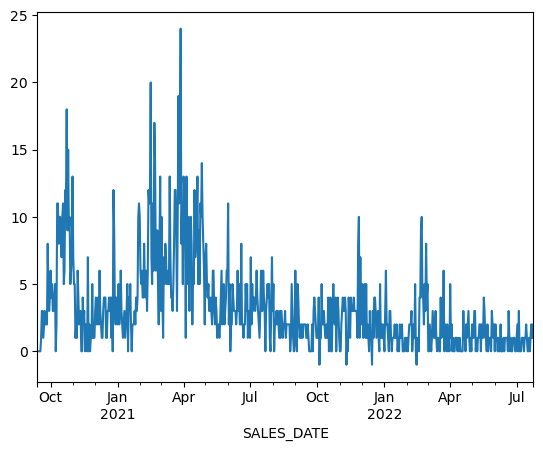

In [14]:
train_sku["DAILY_UNITS"].plot()

### STL Decompostion

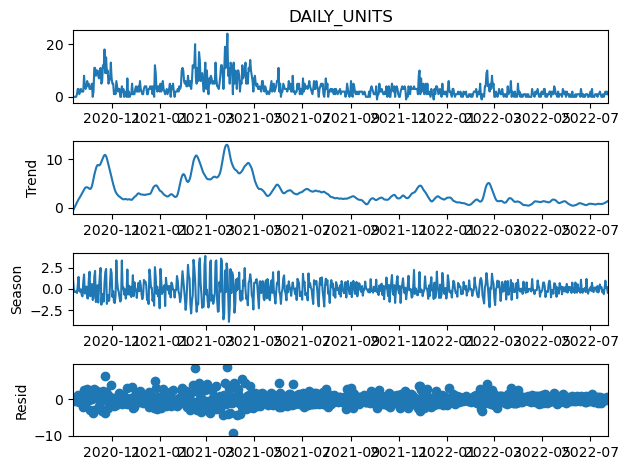

In [15]:
from statsmodels.tsa.seasonal import STL
res = STL(train_sku["DAILY_UNITS"]).fit()
res.plot()
plt.show()

In [16]:
res.trend + res.seasonal + res.resid

SALES_DATE
2020-09-13    0.0
2020-09-14    0.0
2020-09-15    0.0
2020-09-16    0.0
2020-09-17    0.0
             ... 
2022-07-20    1.0
2022-07-21    2.0
2022-07-22    1.0
2022-07-23    2.0
2022-07-24    1.0
Length: 680, dtype: float64

In [17]:
res.resid.mean()

0.001241939800399376

In [18]:
(train_sku.index == res.resid.index).mean()

1.0

In [19]:
train_sku["STL_resid"] = res.resid
train_sku["STL_trend"] = res.trend
train_sku["STL_seasonal"] = res.seasonal

/var/folders/kb/v0p0ypbd0wx1q2qb1kpxmmcc0000gn/T/ipykernel_6110/3573235626.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_sku["STL_resid"] = res.resid
/var/folders/kb/v0p0ypbd0wx1q2qb1kpxmmcc0000gn/T/ipykernel_6110/3573235626.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_sku["STL_trend"] = res.trend
/var/folders/kb/v0p0ypbd0wx1q2qb1kpxmmcc0000gn/T/ipykernel_6110/3573235626.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[

### XGBoost over STL residual

In [20]:
# check xgboost version
from xgboost import XGBRegressor

In [33]:
# create an xgboost regression model
model1 = XGBRegressor(n_estimators=500, max_depth=7,\
                     eta=0.1, subsample=0.7, colsample_bytree=0.8)
# create an xgboost regression model
model2 = XGBRegressor(n_estimators=500, max_depth=7,\
                     eta=0.1, subsample=0.7, colsample_bytree=0.8)
# create an xgboost regression model
model3 = XGBRegressor(n_estimators=500, max_depth=7,\
                     eta=0.1, subsample=0.7, colsample_bytree=0.8)

In [34]:
train_sku.columns

Index(['DAILY_UNITS', 'if_promo', 'if_competitor', 'min_sales_price',
       'price_delta', 'validation', 'validation_clean', 'DAILY_UNITS_lag1',
       'DAILY_UNITS_lag2', 'DAILY_UNITS_lag3', 'DAILY_UNITS_lag4',
       'DAILY_UNITS_lag5', 'DAILY_UNITS_lag6', 'DAILY_UNITS_lag7',
       'DAILY_UNITS_lag8', 'DAILY_UNITS_lag9', 'DAILY_UNITS_lag10',
       'STL_resid', 'STL_trend', 'STL_seasonal'],
      dtype='object')

In [35]:
train_sku.dtypes

DAILY_UNITS           object
if_promo              object
if_competitor         object
min_sales_price       object
price_delta           object
validation            object
validation_clean      object
DAILY_UNITS_lag1      object
DAILY_UNITS_lag2      object
DAILY_UNITS_lag3      object
DAILY_UNITS_lag4      object
DAILY_UNITS_lag5      object
DAILY_UNITS_lag6      object
DAILY_UNITS_lag7      object
DAILY_UNITS_lag8      object
DAILY_UNITS_lag9      object
DAILY_UNITS_lag10     object
STL_resid            float64
STL_trend            float64
STL_seasonal         float64
dtype: object

In [36]:
pred_cols = ['if_promo', 'if_competitor', 'min_sales_price',
       'price_delta'] + [col for col in train_sku.columns if "lag" in col]
pred_cols

['if_promo',
 'if_competitor',
 'min_sales_price',
 'price_delta',
 'DAILY_UNITS_lag1',
 'DAILY_UNITS_lag2',
 'DAILY_UNITS_lag3',
 'DAILY_UNITS_lag4',
 'DAILY_UNITS_lag5',
 'DAILY_UNITS_lag6',
 'DAILY_UNITS_lag7',
 'DAILY_UNITS_lag8',
 'DAILY_UNITS_lag9',
 'DAILY_UNITS_lag10']

In [37]:
X = train_sku[pred_cols].astype(np.float64)
y_trend = train_sku['STL_trend'].astype(np.float64)
y_resid = train_sku['STL_resid'].astype(np.float64)
y_seasonal = train_sku['STL_seasonal'].astype(np.float64)

In [38]:
model1.fit(X,y_trend)
model2.fit(X,y_resid)
model3.fit(X,y_seasonal)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.8,
             early_stopping_rounds=None, enable_categorical=False, eta=0.1,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.100000001, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=7, max_leaves=0, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=500, n_jobs=0,
             num_parallel_tree=1, predictor='auto', ...)

In [39]:
X_test = validation_sku[pred_cols].astype(np.float64)

In [40]:
y_trend_pred = model1.predict(X_test)
y_resid_pred = model2.predict(X_test)
y_seasonal_pred = model3.predict(X_test)

In [41]:
y_pred = y_trend_pred+y_resid_pred+y_seasonal_pred
y_pred

array([ 0.18760526,  1.3306385 ,  1.1979482 ,  0.31358045, -0.40824723,
        0.9615911 ,  1.4005773 ], dtype=float32)

In [42]:
validation_sku

,DAILY_UNITS,if_promo,if_competitor,min_sales_price,price_delta,validation,validation_clean,DAILY_UNITS_lag1,DAILY_UNITS_lag2,DAILY_UNITS_lag3,DAILY_UNITS_lag4,DAILY_UNITS_lag5,DAILY_UNITS_lag6,DAILY_UNITS_lag7,DAILY_UNITS_lag8,DAILY_UNITS_lag9,DAILY_UNITS_lag10
SALES_DATE,,,,,,,,,,,,,,,,,
2022-07-25,0,0,1,944.99,95.99,True,True,1,2,1,2,1,0,1,0,0,1
2022-07-26,1,1,1,879.99,31.99,True,True,0,1,2,1,2,1,0,1,0,0
2022-07-27,3,1,1,879.99,30.99,True,True,1,0,1,2,1,2,1,0,1,0
2022-07-28,0,0,1,944.99,95.99,True,True,3,1,0,1,2,1,2,1,0,1
2022-07-29,0,0,0,944.99,-944.99,True,True,0,3,1,0,1,2,1,2,1,0
2022-07-30,0,0,0,944.99,-944.99,True,True,0,0,3,1,0,1,2,1,2,1
2022-07-31,1,1,0,829.99,-829.99,True,True,0,0,0,3,1,0,1,2,1,2


In [43]:
np.mean((validation_sku["DAILY_UNITS"]-y_pred)**2)**0.5

0.8230627792908871

In [2]:
validation_sku["DAILY_UNITS"].plot()

NameError: name 'validation_sku' is not defined